In [1]:
# Libraries
import time
import glob
import os
import os.path
import fnmatch
from pathlib import Path
import pandas as pd                                     # Data analysis and manipultion tool
import numpy as np                                      # Fundamental package for linear algebra and multidimensional arrays
import matplotlib.pyplot as plt
import cv2                                              # Library for image processing
import datetime as dt
from PIL import Image
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split    # For splitting the data into train and validation set
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.utils import shuffle

# TensorFlow / Keras
import tensorflow as tf                                 # Deep Learning Tool
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import datasets, layers, models, losses, Model, optimizers
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D, MaxPool2D,BatchNormalization, Flatten, Input, GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import pickle

from IPython.core.display import display, HTML
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)


## Function 

In [3]:
# Function to plot History of NN  Learning.
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()

In [2]:
def salt(img, n):
    for k in range(n):
        i = int(np.random.random() * img.shape[1])
        j = int(np.random.random() * img.shape[0])
        if img.ndim == 2:
            img[j,i] = 255
        elif img.ndim == 3:
            img[j,i,0]= 255
            img[j,i,1]= 255
            img[j,i,2]= 255
        return img


# BG Remover  inspired by : @Messaoud Makhlouf 
def bg_remov(image):
    result = salt(image, 10)
    median = cv2.medianBlur(result,5)
    gray = cv2.cvtColor(median, cv2.COLOR_BGR2GRAY)
    (thresh, blackAndWhiteImage) = cv2.threshold(gray, 85, 255, cv2.THRESH_BINARY)
    
    return blackAndWhiteImage

# Loading Data

In [4]:
%%time
filepaths = []
filenames = []
root_folder = '../input/ecg-images/MI/'
for filename in os.listdir(root_folder):
    if filename.endswith(".jpg"):
        fp =os.path.join(root_folder, filename)
        filepaths.append(fp)
        filenames.append(filename)

MI = pd.DataFrame(filenames, columns=['filename'])
MI['filepaths'] = filepaths
MI['label'] = 'MI'
MI.head()

CPU times: user 4.79 ms, sys: 1.13 ms, total: 5.92 ms
Wall time: 46.8 ms


,filename,filepaths,label
0,MI(12).jpg,../input/ecg-images/MI/MI(12).jpg,MI
1,MI(225).jpg,../input/ecg-images/MI/MI(225).jpg,MI
2,MI(164).jpg,../input/ecg-images/MI/MI(164).jpg,MI
3,MI(84).jpg,../input/ecg-images/MI/MI(84).jpg,MI
4,MI(88).jpg,../input/ecg-images/MI/MI(88).jpg,MI


In [5]:
%%time
filepaths = []
filenames = []
root_folder = '../input/ecg-images/Normal/'
for filename in os.listdir(root_folder):
    if filename.endswith(".jpg"):
        fp =os.path.join(root_folder, filename)
        filepaths.append(fp)
        filenames.append(filename)

Normal = pd.DataFrame(filenames, columns=['filename'])
Normal['filepaths'] = filepaths
Normal['label'] = 'Normal'
Normal.head()

CPU times: user 2.87 ms, sys: 2.16 ms, total: 5.03 ms
Wall time: 34.9 ms


,filename,filepaths,label
0,Normal(63).jpg,../input/ecg-images/Normal/Normal(63).jpg,Normal
1,Normal(37).jpg,../input/ecg-images/Normal/Normal(37).jpg,Normal
2,Normal(175).jpg,../input/ecg-images/Normal/Normal(175).jpg,Normal
3,Normal(161).jpg,../input/ecg-images/Normal/Normal(161).jpg,Normal
4,Normal(148).jpg,../input/ecg-images/Normal/Normal(148).jpg,Normal


In [6]:
df = pd.concat([MI,Normal],ignore_index=True)
df.head()

,filename,filepaths,label
0,MI(12).jpg,../input/ecg-images/MI/MI(12).jpg,MI
1,MI(225).jpg,../input/ecg-images/MI/MI(225).jpg,MI
2,MI(164).jpg,../input/ecg-images/MI/MI(164).jpg,MI
3,MI(84).jpg,../input/ecg-images/MI/MI(84).jpg,MI
4,MI(88).jpg,../input/ecg-images/MI/MI(88).jpg,MI


In [7]:
%%time
# Labelencoder to encode the labels 
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])

data = []     # initialize an empty numpy array
image_size = 256      # image size taken is 100 here. one can take other size too
# the size of the images is between 52 and 75 so choose what ever size you want.
for i in range(len(df)):
    # here I read the image 
    img_array = cv2.imread(df['filepaths'][i])   # converting the image to gray scale
    img_array = bg_remov(img_array)
    new_img_array = cv2.resize(img_array, (image_size, image_size)) 
    data.append([new_img_array, df['label'][i]])

CPU times: user 22 s, sys: 854 ms, total: 22.8 s
Wall time: 25.6 s


In [8]:
np.random.shuffle(data)

x = []
y = []
for image in data:
    x.append(image[0])
    y.append(image[1])

In [9]:
# converting x & y to numpy array as they are list
x = np.array(x)
y = np.array(y)

In [10]:
x = x.reshape(-1, 256, 256, 1)

In [11]:
# split the data

trsplit=.8
vsplit=.1
dsplit=vsplit/(1-trsplit)

X_train, X_dum, y_train, y_dum=train_test_split(x,y, train_size=trsplit, shuffle=True, random_state=123)
X_val, X_test, y_val, y_test=train_test_split(X_dum, y_dum, train_size= dsplit, shuffle=True, random_state=123)
#X_train, X_val, y_train, y_val = train_test_split(x,y,test_size=0.3, random_state = 123)

In [12]:
X_train = X_train.astype('float32')/255
X_val = X_val.astype('float32')/255
X_test = X_test.astype('float32')/255


In [15]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape,X_test.shape, y_test.shape

((383, 256, 256, 1),
 (383,),
 (48, 256, 256, 1),
 (48,),
 (48, 256, 256, 1),
 (48,))

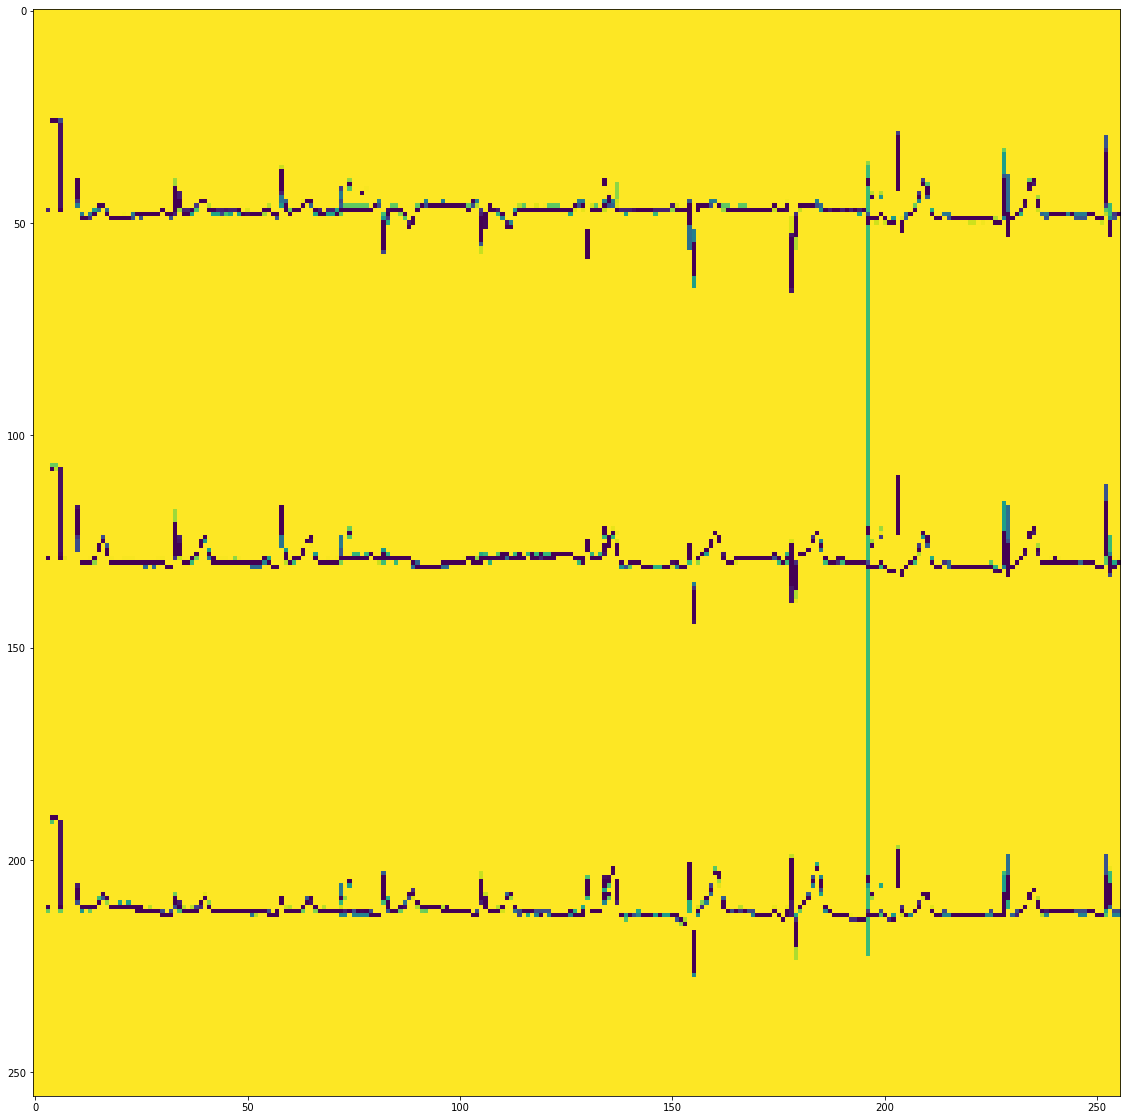

In [16]:
plt.figure(figsize=(20,20))
plt.imshow(X_train[0])

In [17]:
cnn = tf.keras.models.Sequential([
tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(256, 256, 1)),
tf.keras.layers.MaxPooling2D((2, 2)),

tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
tf.keras.layers.MaxPooling2D((2, 2)),

# tf.keras.layers.Flatten(input_shape=(100, 100, 1)),
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(64, activation='relu'),
tf.keras.layers.Dense(1, activation='sigmoid')
])

cnn.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 246016)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                15745088  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6

In [18]:
# you can use hostory to check on the progress of your model with tensorboard...
history = cnn.fit(X_train, y_train, batch_size=128, epochs=20, validation_data=(X_val, y_val))

Epoch 1/20
3/3 [==============================] - 9s 875ms/step - loss: 2.4377 - accuracy: 0.5072 - val_loss: 1.6429 - val_accuracy: 0.4792
Epoch 2/20
3/3 [==============================] - 0s 130ms/step - loss: 1.1199 - accuracy: 0.5205 - val_loss: 0.6687 - val_accuracy: 0.5417
Epoch 3/20
3/3 [==============================] - 0s 124ms/step - loss: 0.6633 - accuracy: 0.4866 - val_loss: 0.6419 - val_accuracy: 0.5208
Epoch 4/20
3/3 [==============================] - 0s 127ms/step - loss: 0.6308 - accuracy: 0.6027 - val_loss: 0.6091 - val_accuracy: 0.5208
Epoch 5/20
3/3 [==============================] - 0s 159ms/step - loss: 0.6053 - accuracy: 0.5750 - val_loss: 0.5337 - val_accuracy: 0.8750
Epoch 6/20
3/3 [==============================] - 0s 139ms/step - loss: 0.5371 - accuracy: 0.8748 - val_loss: 0.4840 - val_accuracy: 0.9792
Epoch 7/20
3/3 [==============================] - 0s 133ms/step - loss: 0.4759 - accuracy: 0.9579 - val_loss: 0.4002 - val_accuracy: 0.9167
Epoch 8/20
3/3 [====

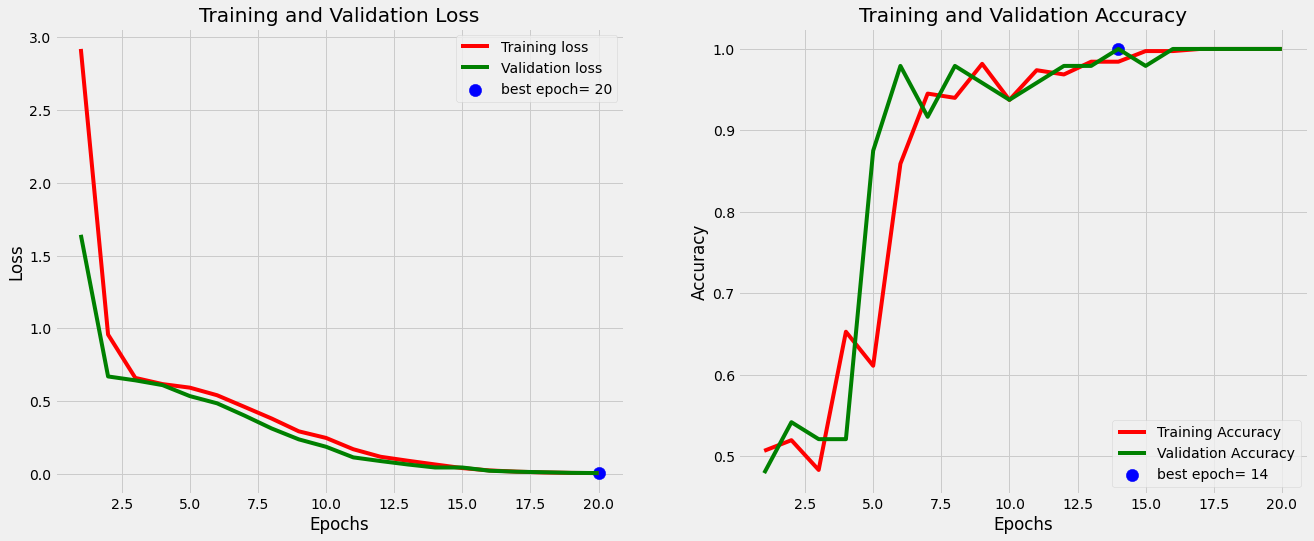

In [19]:
tr_plot(history,0)


In [20]:
score_head_model= cnn.evaluate(X_val,y_val)
print("Test Loss:", score_head_model[0])
print("Test Accuracy:", score_head_model[1])

2/2 [==============================] - 0s 80ms/step - loss: 0.0043 - accuracy: 1.0000
Test Loss: 0.004348976071923971
Test Accuracy: 1.0


In [27]:
ypred = cnn.predict(X_test)


array([0.00117288], dtype=float32)

In [28]:
prediction = []
for i in range(0,len(ypred)):
    if ypred[i]<=0.5:
        out=0
    else:
        out=1
  #print(out)
    prediction.append(out)

In [29]:
predictions = le.inverse_transform(prediction)

In [30]:
predictions

array(['MI', 'MI', 'MI', 'MI', 'MI', 'MI', 'Normal', 'Normal', 'MI',
       'Normal', 'MI', 'Normal', 'MI', 'Normal', 'Normal', 'MI', 'Normal',
       'Normal', 'MI', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal',
       'Normal', 'Normal', 'MI', 'Normal', 'MI', 'MI', 'MI', 'Normal',
       'MI', 'MI', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'MI',
       'MI', 'Normal', 'MI', 'MI', 'MI', 'Normal', 'MI', 'Normal'],
      dtype=object)

In [37]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00        25

    accuracy                           1.00        48
   macro avg       1.00      1.00      1.00        48
weighted avg       1.00      1.00      1.00        48



In [38]:
cnn.save("./ecg_cnn_model.h5")
#model saved..

# Another Experiment

In [39]:
%%time
# Labelencoder to encode the labels 
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])

data2 = []     # initialize an empty numpy array
#image_size = 256      # image size taken is 100 here. one can take other size too
# the size of the images is between 52 and 75 so choose what ever size you want.
for i in range(len(df)):
    # here I read the image 
    img_array = cv2.imread(df['filepaths'][i])   # converting the image to gray scale
    img_array = bg_remov(img_array)
    new_img_array = cv2.resize(img_array, (400, 1000)) 
    data2.append([new_img_array, df['label'][i]])

CPU times: user 21.3 s, sys: 502 ms, total: 21.8 s
Wall time: 21.2 s


In [40]:
np.random.shuffle(data2)

x2 = []
y2 = []
for image in data2:
    x2.append(image[0])
    y2.append(image[1])

In [41]:
# converting x & y to numpy array as they are list
x2 = np.array(x2)
y2 = np.array(y2)

In [42]:
x2 = x2.reshape(-1, 400, 1000, 1)

In [43]:
# split the data

trsplit=.8
vsplit=.1
dsplit=vsplit/(1-trsplit)

X2_train, X2_dum, y2_train, y2_dum=train_test_split(x2,y2, train_size=trsplit, shuffle=True, random_state=123)
X2_val, X2_test, y2_val, y2_test=train_test_split(X2_dum, y2_dum, train_size= dsplit, shuffle=True, random_state=123)


In [44]:
X2_train = X2_train.astype('float32')/255
X2_val = X2_val.astype('float32')/255
X2_test = X2_test.astype('float32')/255

In [45]:
X2_train.shape, y2_train.shape, X2_val.shape, y2_val.shape, X2_test.shape, y2_test.shape

((383, 400, 1000, 1),
 (383,),
 (48, 400, 1000, 1),
 (48,),
 (48, 400, 1000, 1),
 (48,))

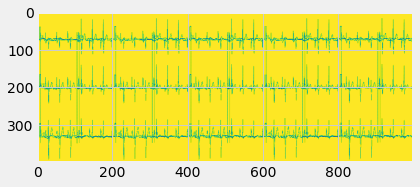

In [46]:
plt.imshow(X2_train[0])

In [47]:
cnn2 = tf.keras.models.Sequential([
tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(400, 1000, 1)),
tf.keras.layers.MaxPooling2D((2, 2)),

tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
tf.keras.layers.MaxPooling2D((2, 2)),

# tf.keras.layers.Flatten(input_shape=(100, 100, 1)),
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(64, activation='relu'),
tf.keras.layers.Dense(1, activation='sigmoid')
])

cnn2.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
cnn2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 398, 998, 32)      320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 199, 499, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 197, 497, 64)      18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 98, 248, 64)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1555456)           0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                99549248  
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [ ]:
# you can use hostory to check on the progress of your model with tensorboard...
history2 = cnn2.fit(X2_train, y2_train, batch_size=128, epochs=10, validation_data=(X2_val, y2_val),workers=-1)

In [ ]:
tr_plot(history2,0)
